# Quantile Regression and LSTM's in keras

In this notebook we explore some basic example of how quantile regression can be performed when working with LSTM's. In short quantile regression for time-series is aiming at estimating or predicting the quantiles of the sampling distribution for a time point. For example when using the Mean Absolute Error loss, this is in theory the same as regressing for the .5 quantile. 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from datetime import datetime

print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers

2.0.0


# Basic LSTM and Quantile regression on dummy data

## Create dummy training data

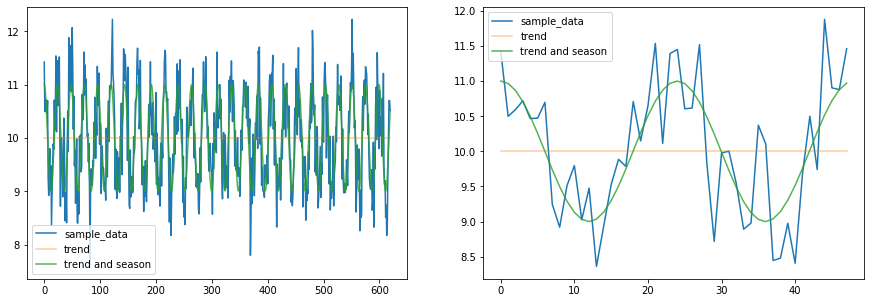

In [2]:
"""
Create dummy data
"""

samples = 620
season_number = 24
slope_trend = 0  # a non-zero trend gives the model quite some trouble. For illustration purposes set to 0.
intercept_trend = 10
noise_sigma = .5

trend = np.linspace(0, samples, samples)
season = np.cos(trend * 2 *np.pi / season_number)
trend = slope_trend * trend + intercept_trend
noise = np.random.normal(0, noise_sigma, samples)

sample_data_ts = trend + season + noise

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(sample_data_ts, label='sample_data')
ax[0].plot(trend, label='trend', alpha=.4)
ax[0].plot(trend + season, label='trend and season', alpha=.8)
ax[0].legend()

ax[1].plot(sample_data_ts[:48], label='sample_data')
ax[1].plot(trend[:48], label='trend', alpha=.4)
ax[1].plot((trend + season)[:48], label='trend and season', alpha=.8)
ax[1].legend()

plt.show()

In [3]:
def split_sequence(sequence, n_steps):
    """
    Splits a time-series object into sub-series to create samples for training
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

(464, 36) (464,)
(84, 36) (84,)


array([[11.42207683, 10.49696561, 10.5947993 , ...,  8.89172539,
         8.97857954, 10.37134077],
       [10.49696561, 10.5947993 , 10.71872338, ...,  8.97857954,
        10.37134077, 10.10636923],
       [10.5947993 , 10.71872338, 10.46661292, ..., 10.37134077,
        10.10636923,  8.44643032],
       ...,
       [ 9.82462635,  9.99361512,  8.70588129, ...,  9.83761385,
         8.87977923,  9.53842107],
       [ 9.99361512,  8.70588129,  9.64607119, ...,  8.87977923,
         9.53842107,  9.31564687],
       [ 8.70588129,  9.64607119,  9.42118174, ...,  9.53842107,
         9.31564687, 10.76677683]])

array([[ 9.92125373, 11.06614143, 11.4137978 , ...,  9.22928447,
        10.16949767,  9.22134746],
       [11.06614143, 11.4137978 , 11.22377854, ..., 10.16949767,
         9.22134746,  8.96954559],
       [11.4137978 , 11.22377854, 10.9026397 , ...,  9.22134746,
         8.96954559,  9.13838454],
       ...,
       [ 9.64958014,  9.22698812,  9.09837389, ...,  8.35479834,
         9.36520027,  9.95134795],
       [ 9.22698812,  9.09837389,  9.03798663, ...,  9.36520027,
         9.95134795, 10.70112115],
       [ 9.09837389,  9.03798663,  9.11032411, ...,  9.95134795,
        10.70112115, 10.69870025]])

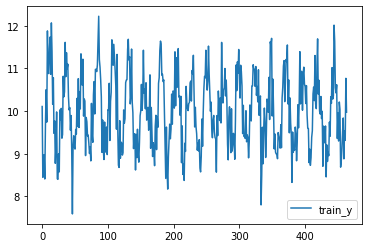

In [4]:
"""
Split training and validation data
"""

split_index = 500
TIMESTEPS_PER_SAMPLE = 36

train_data_ts = sample_data_ts[:split_index]
validation_data_ts = sample_data_ts[split_index:]

train_x, train_y = split_sequence(train_data_ts, TIMESTEPS_PER_SAMPLE)
validation_x, validation_y = split_sequence(validation_data_ts, TIMESTEPS_PER_SAMPLE)

print(train_x.shape, train_y.shape)
print(validation_x.shape, validation_y.shape)

display(train_x, validation_x)

plt.plot(train_y, label='train_y')
plt.legend()
plt.show()

In [5]:
"""
Expected input shape of LSTM is (samples, timesteps, features).
We nee to reshape the training features to identify that we have only one 
feature per sample and timestep (i.e. dealing with univariate timeseries)
"""

train_x = train_x.reshape(train_x.shape[0], TIMESTEPS_PER_SAMPLE, 1)
validation_x = validation_x.reshape(validation_x.shape[0], TIMESTEPS_PER_SAMPLE, 1)

# Create some LSTM models to compare

## Basic LSTM based with mean squared error loss 

In [6]:
"""
Basic LSTM with mean squared error for benchmark
"""

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape = (TIMESTEPS_PER_SAMPLE, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [7]:
lstm_model.fit(train_x, train_y, epochs = 20, verbose=1, validation_data = (validation_x, validation_y))

Train on 464 samples, validate on 84 samples
Epoch 1/20
464/464 [==============================] - 4s 8ms/sample - loss: 35.7392 - val_loss: 7.4566
Epoch 2/20
464/464 [==============================] - 1s 2ms/sample - loss: 2.4242 - val_loss: 0.9398
Epoch 3/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.7569 - val_loss: 0.8277
Epoch 4/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.6683 - val_loss: 0.7811
Epoch 5/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.6157 - val_loss: 0.7060
Epoch 6/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.5181 - val_loss: 0.4946
Epoch 7/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.3946 - val_loss: 0.4417
Epoch 8/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.3244 - val_loss: 0.4077
Epoch 9/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.2956 - val_loss: 0.3675
Epoch 10/20
464/464 [===============

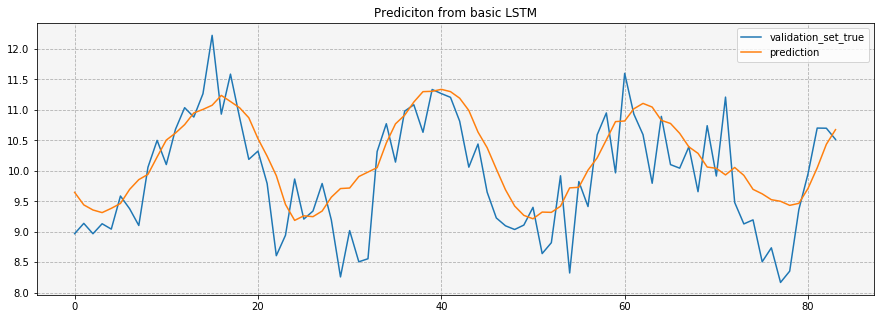

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(validation_y, label='validation_set_true')
ax.plot(lstm_model.predict(validation_x), label='prediction')
# ax.plot((trend + season)[split_index:])
ax.set_title("Prediciton from basic LSTM")
ax.legend()
ax.grid(linestyle="--")
ax.set_facecolor('whitesmoke')
plt.show()

## LSTM using quantile regression

In [9]:
"""
LSTM with mae, which in theory is the same as quantile regression for the .5 quantile
"""

lstm_model_mae = tf.keras.models.clone_model(lstm_model)
lstm_model_mae.compile(optimizer='adagrad', loss='mae')

In [10]:
lstm_model_mae.fit(train_x, train_y, epochs = 20, verbose=1, validation_data = (validation_x, validation_y))

Train on 464 samples, validate on 84 samples
Epoch 1/20
464/464 [==============================] - 3s 7ms/sample - loss: 1.4052 - val_loss: 0.8992
Epoch 2/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.7587 - val_loss: 1.1660
Epoch 3/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.7014 - val_loss: 0.8967
Epoch 4/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.6724 - val_loss: 0.7174
Epoch 5/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.6344 - val_loss: 0.7179
Epoch 6/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.6232 - val_loss: 0.6916
Epoch 7/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.6096 - val_loss: 0.6957
Epoch 8/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.5990 - val_loss: 0.6305
Epoch 9/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.5696 - val_loss: 0.6159
Epoch 10/20
464/464 [================

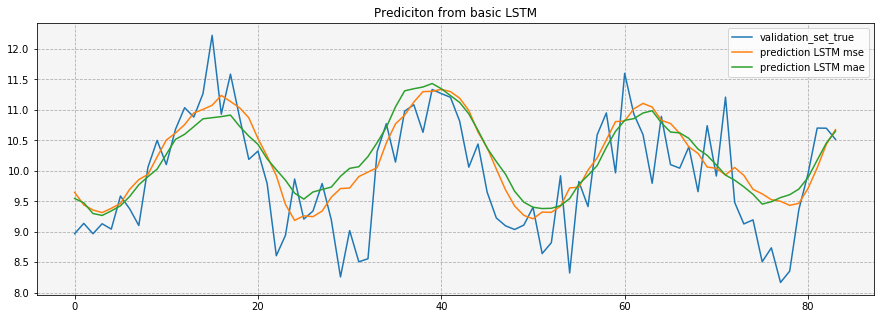

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(validation_y, label='validation_set_true')
ax.plot(lstm_model.predict(validation_x), label='prediction LSTM mse')
ax.plot(lstm_model_mae.predict(validation_x), label='prediction LSTM mae')
# ax.plot((trend + season)[split_index:])
ax.set_title("Prediciton from basic LSTM")
ax.legend()
ax.grid(linestyle="--")
ax.set_facecolor('whitesmoke')
plt.show()

In [12]:
"""
Custom loss function to do quantile regression on other quantiles than the median
source: https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/
"""

def quantile_loss(q, y_p, y):
        e = y_p-y
        return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))

In [13]:
"""
Custom LSTM with quantile regression
"""

model_quantile_regression = tf.keras.models.clone_model(lstm_model)
quantile = 0.5
model_quantile_regression.compile(
    optimizer='adam', 
    loss=lambda y_p, y: quantile_loss(quantile, y_p, y)
)

In [14]:
model_quantile_regression.fit(
    train_x, train_y, epochs = 20, verbose=1,
    validation_data = (validation_x, validation_y)
)

Train on 464 samples, validate on 84 samples
Epoch 1/20
464/464 [==============================] - 3s 7ms/sample - loss: 1.9480 - val_loss: 0.5252
Epoch 2/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.5117 - val_loss: 0.4320
Epoch 3/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.3782 - val_loss: 0.4245
Epoch 4/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.3654 - val_loss: 0.4155
Epoch 5/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.3592 - val_loss: 0.4089
Epoch 6/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.3631 - val_loss: 0.4175
Epoch 7/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.3652 - val_loss: 0.4148
Epoch 8/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.3639 - val_loss: 0.3942
Epoch 9/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.3397 - val_loss: 0.3855
Epoch 10/20
464/464 [================

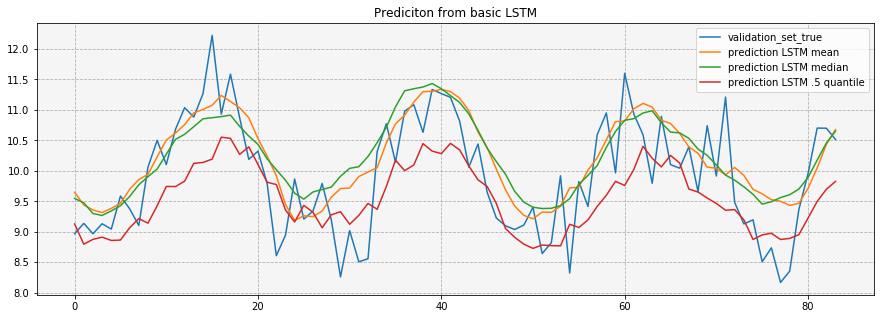

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(validation_y, label='validation_set_true')
ax.plot(lstm_model.predict(validation_x), label='prediction LSTM mean')
ax.plot(lstm_model_mae.predict(validation_x), label='prediction LSTM median')
ax.plot(model_quantile_regression.predict(validation_x), label='prediction LSTM .5 quantile')
# ax.plot((trend + season)[split_index:])
ax.set_title("Prediciton from basic LSTM")
ax.legend()
ax.grid(linestyle="--")
ax.set_facecolor('whitesmoke')
plt.show()

In [16]:
"""
Regression on .9 quantile
"""
model_quantile_regression_90 = tf.keras.models.clone_model(lstm_model)
quantile = 0.9
model_quantile_regression_90.compile(
    optimizer='adam', 
    loss=lambda y_p, y: quantile_loss(quantile, y_p, y)
)

In [17]:
model_quantile_regression_90.fit(
    train_x, train_y, epochs = 20, verbose=1,
    validation_data = (validation_x, validation_y)
)

Train on 464 samples, validate on 84 samples
Epoch 1/20
464/464 [==============================] - 3s 7ms/sample - loss: 0.6528 - val_loss: 0.1294
Epoch 2/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1396 - val_loss: 0.1665
Epoch 3/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1363 - val_loss: 0.1184
Epoch 4/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1121 - val_loss: 0.1116
Epoch 5/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1093 - val_loss: 0.1137
Epoch 6/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1100 - val_loss: 0.1124
Epoch 7/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1144 - val_loss: 0.1126
Epoch 8/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1042 - val_loss: 0.1255
Epoch 9/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1151 - val_loss: 0.1092
Epoch 10/20
464/464 [================

In [18]:
"""
Regression on .1 quantile
"""
model_quantile_regression_10 = tf.keras.models.clone_model(lstm_model)
quantile = 0.1
model_quantile_regression_10.compile(
    optimizer='adam', 
    loss=lambda y_p, y: quantile_loss(quantile, y_p, y)
)

In [19]:
model_quantile_regression_10.fit(
    train_x, train_y, epochs = 20, verbose=1,
    validation_data = (validation_x, validation_y)
)

Train on 464 samples, validate on 84 samples
Epoch 1/20
464/464 [==============================] - 3s 7ms/sample - loss: 0.7020 - val_loss: 0.6308
Epoch 2/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.4585 - val_loss: 0.2120
Epoch 3/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.3136 - val_loss: 0.1894
Epoch 4/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1485 - val_loss: 0.1407
Epoch 5/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1454 - val_loss: 0.1427
Epoch 6/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1346 - val_loss: 0.1417
Epoch 7/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1216 - val_loss: 0.1221
Epoch 8/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1203 - val_loss: 0.1262
Epoch 9/20
464/464 [==============================] - 1s 2ms/sample - loss: 0.1225 - val_loss: 0.1442
Epoch 10/20
464/464 [================

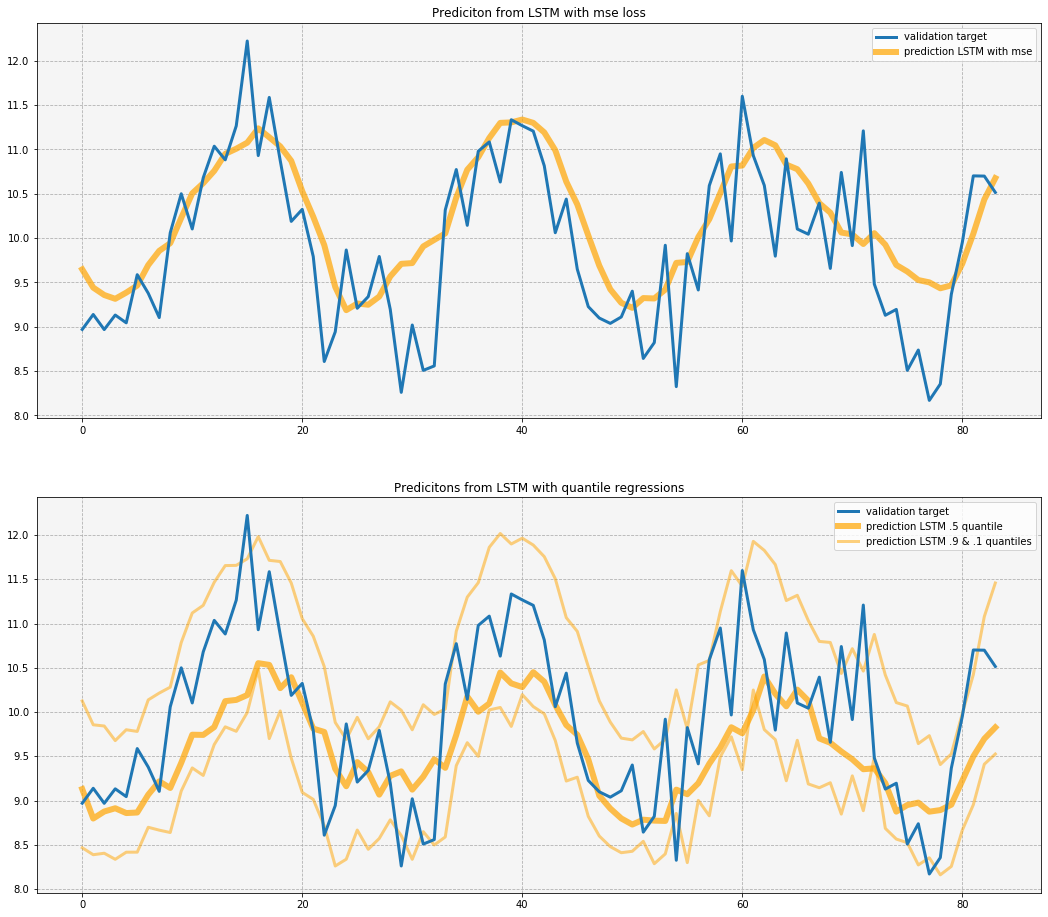

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(18, 16))
for axis in ax:
    axis.plot(validation_y, label='validation target', linewidth=3, zorder=10)

ax[0].plot(lstm_model.predict(validation_x), label='prediction LSTM with mse',
       linewidth=6, alpha = .7, color='orange')

#ax[1].plot(lstm_model_mae.predict(validation_x), label='prediction LSTM mae / median prediciotn')
ax[1].plot(model_quantile_regression.predict(validation_x), label='prediction LSTM .5 quantile',
          linewidth=6, alpha=.7, color='orange')
ax[1].plot(model_quantile_regression_90.predict(validation_x), label='prediction LSTM .9 & .1 quantiles',
          linewidth=3, alpha=.5, color='orange')
ax[1].plot(model_quantile_regression_10.predict(validation_x), label='__no_legend__',
          linewidth=3, alpha=.5, color='orange')
# ax.plot((trend + season)[split_index:])

ax[0].set_title("Prediciton from LSTM with mse loss")
ax[1].set_title("Predicitons from LSTM with quantile regressions")

for axis in ax:
    axis.legend()
    axis.grid(linestyle="--")
    axis.set_facecolor('whitesmoke')

plt.show()

In the above we do 3 individual trainings for models with different parameters to get the 3 quantiles we are interested in. The proper way would be to build a model that outputs all these three at once. This requires some more sophisticated model definition, we don't want to get into that here.

# Trying more elaborate models for better results

In [21]:
"""
Let's try a stacked LSTM for better results
"""

lstm_model_stacked = Sequential()
lstm_model_stacked.add(LSTM(75, activation='relu',
                            input_shape = (TIMESTEPS_PER_SAMPLE, 1),
                            return_sequences=True))
lstm_model_stacked.add(LSTM(75, activation='relu'))
lstm_model_stacked.add(Dense(1))

lstm_model_stacked.compile(
    optimizer='adam', 
    loss=lambda y_p, y: quantile_loss(.5, y_p, y)
)
lstm_model_stacked.fit(train_x, train_y, epochs = 20, verbose=1,
                       validation_data = (validation_x, validation_y))

lstm_model_stacked_10 = tf.keras.models.clone_model(lstm_model_stacked)
lstm_model_stacked_10.compile(
    optimizer='adam', 
    loss=lambda y_p, y: quantile_loss(.1, y_p, y)
)
print("fitting model")
lstm_model_stacked_10.fit(train_x, train_y, epochs = 20, verbose=0,
                       validation_data = (validation_x, validation_y))

lstm_model_stacked_90 = tf.keras.models.clone_model(lstm_model_stacked)
lstm_model_stacked_90.compile(
    optimizer='adam', 
    loss=lambda y_p, y: quantile_loss(.9, y_p, y)
)

print("fitting model")
lstm_model_stacked_90.fit(train_x, train_y, epochs = 20, verbose=0,
                       validation_data = (validation_x, validation_y))

print("Done (ToDO: Add callbacks to track the fit and visualize it)")

Train on 464 samples, validate on 84 samples
Epoch 1/20
464/464 [==============================] - 6s 13ms/sample - loss: 1.9115 - val_loss: 1.0870
Epoch 2/20
464/464 [==============================] - 2s 4ms/sample - loss: 0.5292 - val_loss: 0.4627
Epoch 3/20
464/464 [==============================] - 2s 4ms/sample - loss: 0.3937 - val_loss: 0.3787
Epoch 4/20
464/464 [==============================] - 2s 4ms/sample - loss: 0.3208 - val_loss: 0.3653
Epoch 5/20
464/464 [==============================] - 2s 4ms/sample - loss: 0.2739 - val_loss: 0.2615
Epoch 6/20
464/464 [==============================] - 2s 4ms/sample - loss: 0.2701 - val_loss: 0.2666
Epoch 7/20
464/464 [==============================] - 2s 4ms/sample - loss: 0.2519 - val_loss: 0.2538
Epoch 8/20
464/464 [==============================] - 2s 4ms/sample - loss: 0.2275 - val_loss: 0.2316
Epoch 9/20
464/464 [==============================] - 2s 4ms/sample - loss: 0.2161 - val_loss: 0.2376
Epoch 10/20
464/464 [===============

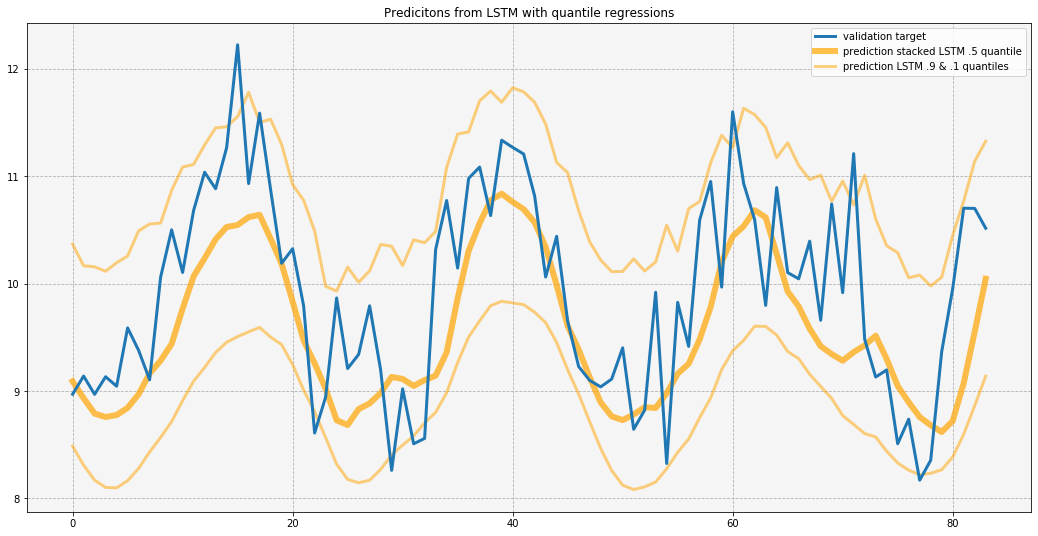

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
ax.plot(validation_y, label='validation target', linewidth=3, zorder=10)

ax.plot(lstm_model_stacked.predict(validation_x), label='prediction stacked LSTM .5 quantile',
       linewidth=6, alpha = .7, color='orange')
ax.plot(lstm_model_stacked_90.predict(validation_x), label='prediction LSTM .9 & .1 quantiles',
           linewidth=3, alpha=.5, color='orange')
ax.plot(lstm_model_stacked_10.predict(validation_x), label='__no_legend__',
          linewidth=3, alpha=.5, color='orange')
# ax.plot((trend + season)[split_index:])

ax.set_title("Predicitons from LSTM with quantile regressions")

ax.legend()
ax.grid(linestyle="--")
ax.set_facecolor('whitesmoke')

plt.show()